In [88]:
import networkx as nx
import json
import matplotlib.pyplot as plt
%matplotlib inline

In [89]:
with open('data/station_connect.json') as fp:
    station_connect = json.load(fp)

with open('data/distance_dict.json') as fp:
    distance_dict = json.load(fp)

with open('data/station_line.json') as fp:
    station_line = json.load(fp)

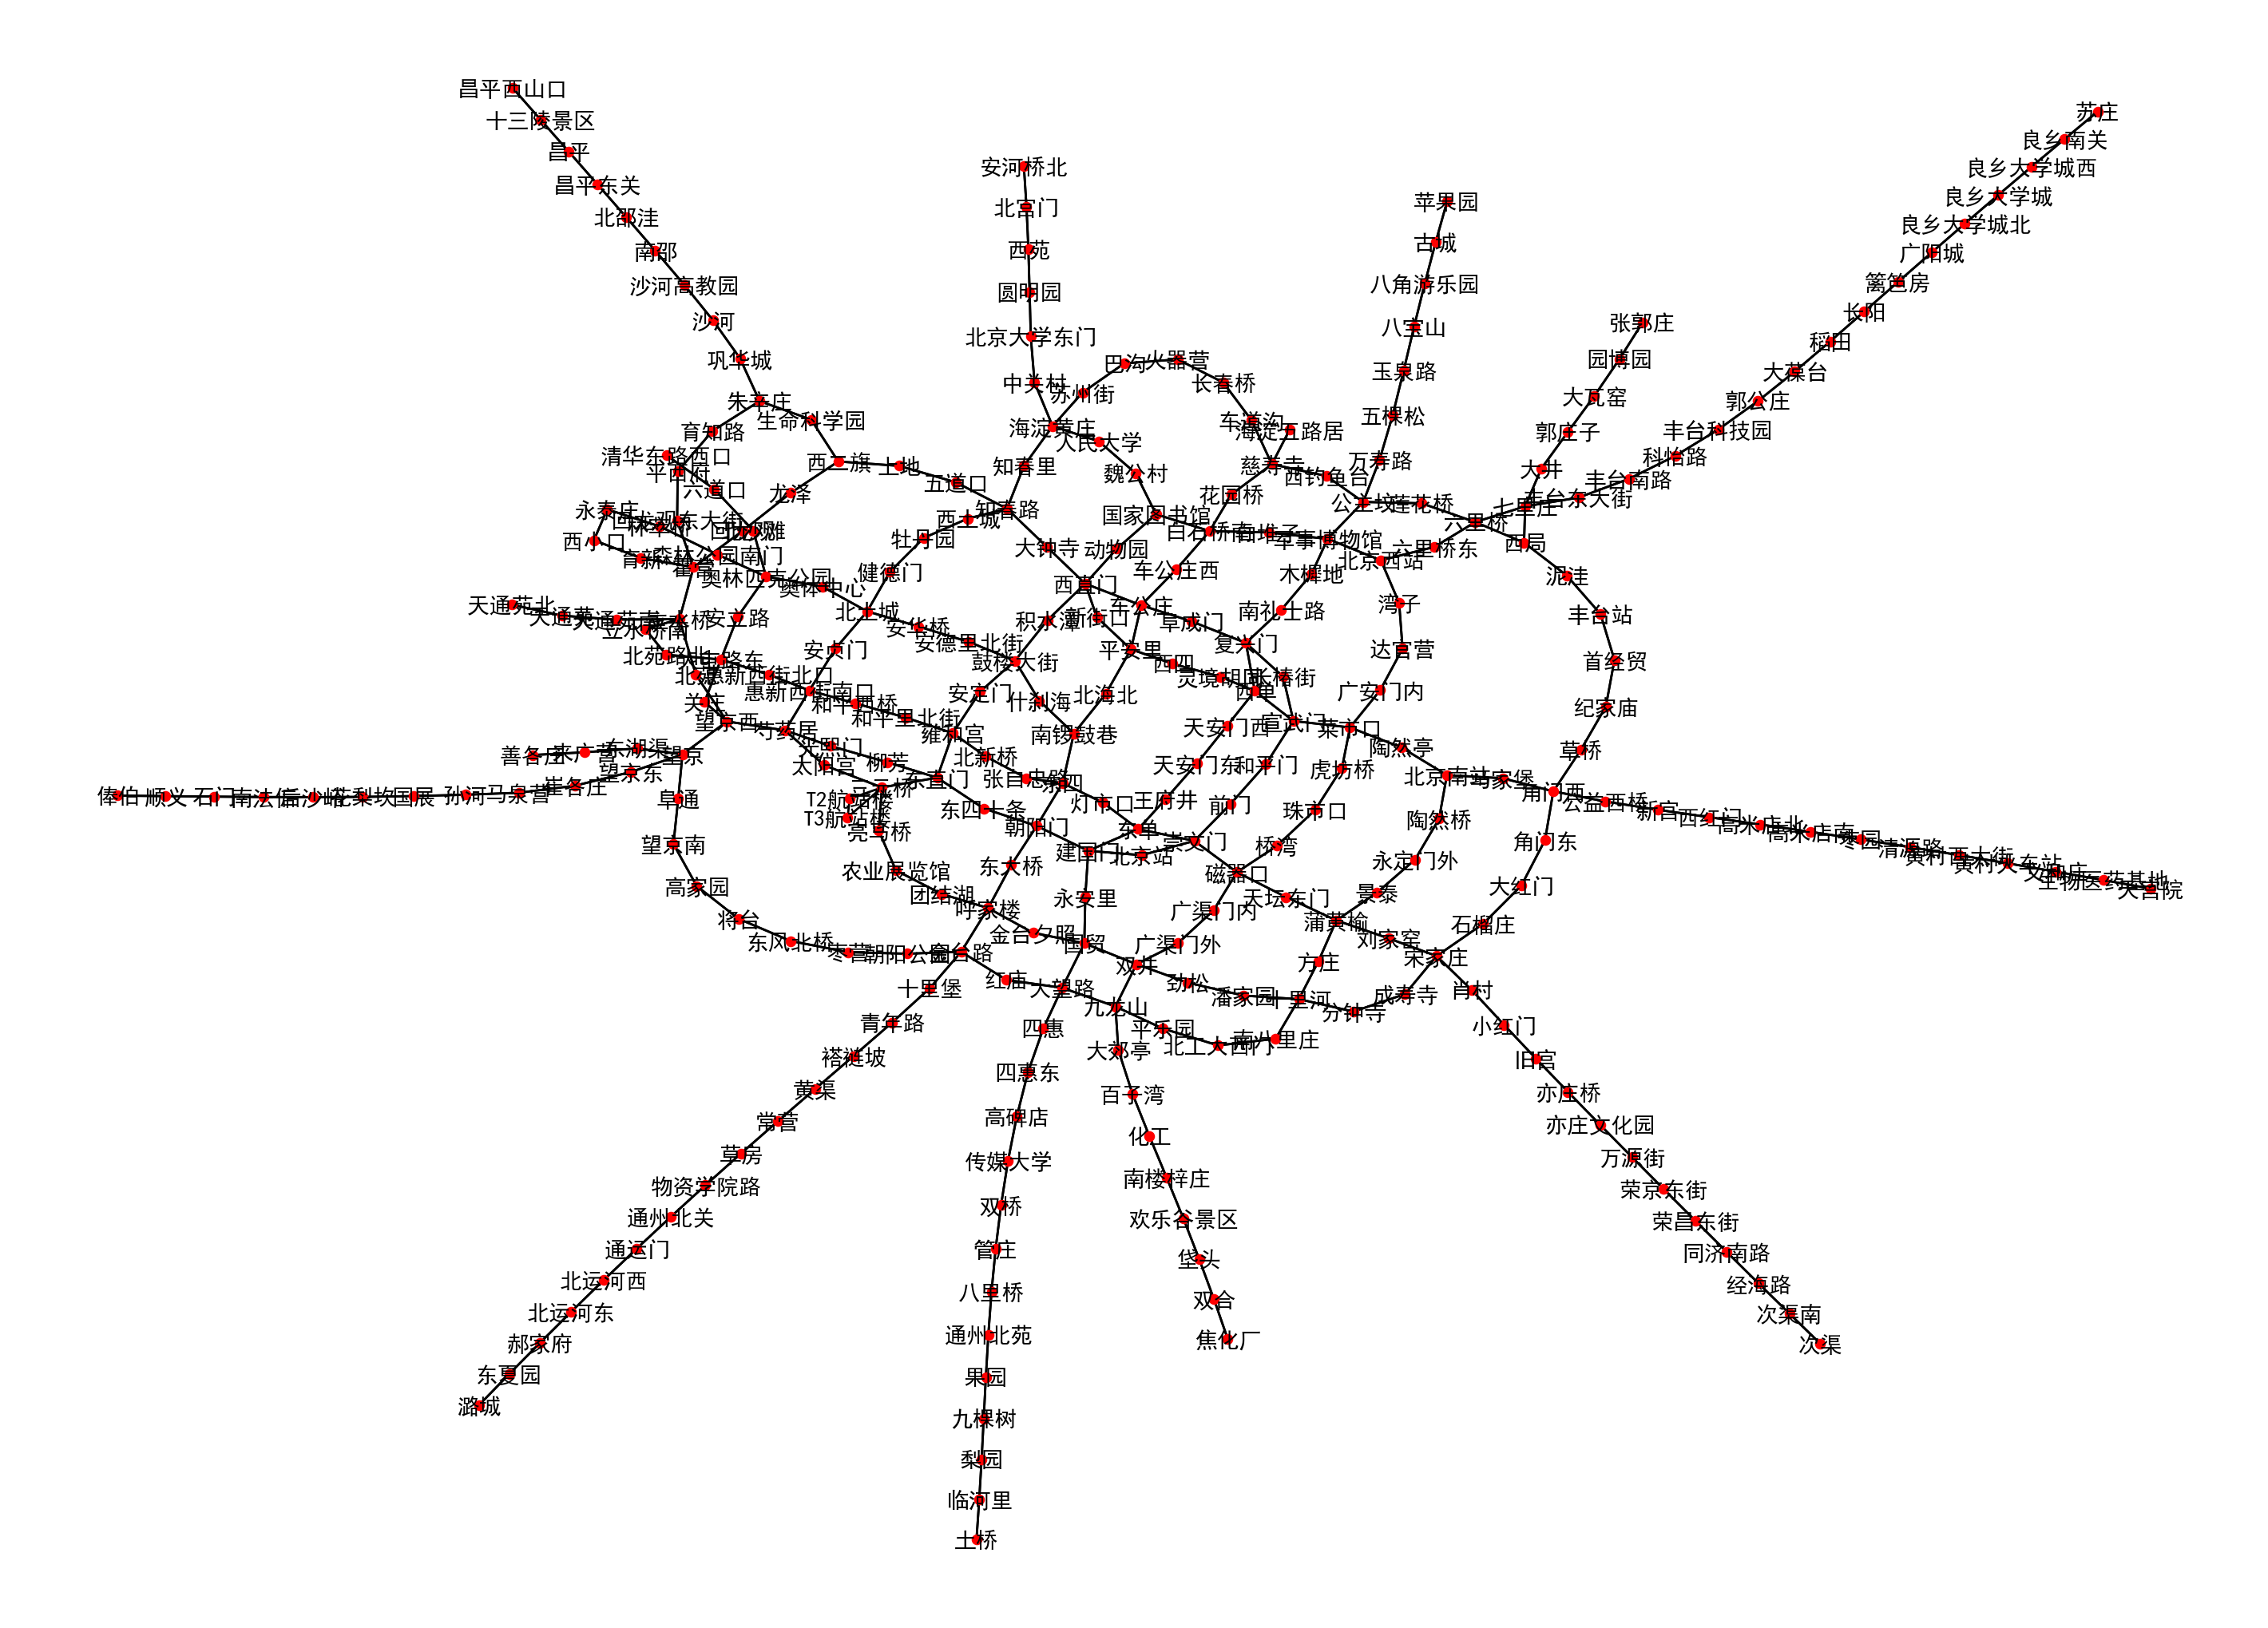

In [90]:
subway_network = nx.DiGraph(station_connect)
pos = nx.kamada_kawai_layout(subway_network, scale=10)
plt.figure(figsize=(14,10), dpi=200)
nx.draw(subway_network, pos, with_labels=True, arrows=False, node_color='r', node_size=15, font_size=10)

In [91]:
def is_goal(destination):
    def _wrap(path, by_way):
        return path[-1]==destination and all([b in path for b in by_way])

    return _wrap

In [92]:
is_goal('南锣鼓巷')(['东单','东四','安贞门','南锣鼓巷'], ['东单','安贞门'])

True

In [93]:
def get_path_length(path):
    """
    计算路径总长度
    :param path:
    :return:
    """
    dist = 0
    for i in range(len(path)-1):
        if path[i+1] not in distance_dict[path[i]]:
            print('{}-{} not in distance_dict'.format(path[i], path[i+1]))
        dist += distance_dict[path[i]][path[i+1]]

    return dist

In [94]:
def get_nega_length(path):
    return -get_path_length(path)

In [95]:
def get_transfer_times(path):
    """
    计算一条路径中的换乘次数
    :param path:
    :return:
    """
    times = 0
    for i in range(1, len(path)-1):

        if len(station_line[path[i]])>1 and \
            len(set(station_line[path[i-1]]).intersection(set(station_line[path[i+1]])))<1:
            times += 1

    return times

In [96]:
def get_comprehensive(path):
    return get_path_length(path) + get_transfer_times(path)

In [97]:
def sort_path(compare_func, beam):
    
    def _sort(pathes):
        return sorted(pathes, key=compare_func)[:beam]
    
    return _sort

In [ ]:
subway_network['牡丹园']

In [98]:
def search(graph, start, is_goal, search_strategy=lambda x:x, by_way=[]):

    pathes = [[start]]
    seen = set()

    while pathes:
        path = pathes.pop(0)
        frontier = path[-1]

        if frontier in seen: continue

        successors = graph[frontier]

        for station in successors:
            
            if station in path:
                
                continue
        
            new_path = path + [station]
            
            pathes.append(new_path)

            if is_goal(new_path, by_way): return new_path

        seen.add(frontier)  # TODO 地铁线路图是一个有环的图，而不是树，因此这种seen的定义方式，会导致有些路径遍历不到（by_way会出问题）
        pathes = search_strategy(pathes)

In [100]:
print(search(subway_network, "车公庄西", is_goal("东直门")))
print(search(subway_network, "车公庄西", is_goal("东四十条")))
print("车公庄西到东四十条换乘 %d 次" % get_transfer_times(search(subway_network, "车公庄西", is_goal("东四十条"))))

['车公庄西', '车公庄', '西直门', '积水潭', '鼓楼大街', '安定门', '雍和宫', '东直门']
['车公庄西', '车公庄', '平安里', '北海北', '南锣鼓巷', '东四', '朝阳门', '东四十条']
车公庄西到东四十条换乘 1 次


In [101]:
# 最短距离
shortest_path = search(subway_network, "圆明园", is_goal("亦庄文化园"), search_strategy=sort_path(get_path_length, beam=100))
print("圆明园 到 亦庄文化园 距离最短的路径长 %.2f 千米" % get_path_length(shortest_path))
print(shortest_path)

圆明园 到 亦庄文化园 距离最短的路径长 34.29 千米
['圆明园', '北京大学东门', '中关村', '海淀黄庄', '知春里', '知春路', '大钟寺', '西直门', '新街口', '平安里', '北海北', '南锣鼓巷', '东四', '灯市口', '东单', '崇文门', '磁器口', '天坛东门', '蒲黄榆', '刘家窑', '宋家庄', '肖村', '小红门', '旧宫', '亦庄桥', '亦庄文化园']


In [102]:
# 最少换乘
shortest_path = search(subway_network, "圆明园", is_goal("亦庄文化园"), search_strategy=sort_path(get_transfer_times, beam=100))
print(shortest_path)
print("圆明园 到 亦庄文化园 最少换乘 %d 次" % get_transfer_times(shortest_path))

['圆明园', '北京大学东门', '中关村', '海淀黄庄', '人民大学', '魏公村', '国家图书馆', '动物园', '西直门', '新街口', '平安里', '西四', '灵境胡同', '西单', '宣武门', '菜市口', '陶然亭', '北京南站', '马家堡', '角门西', '角门东', '大红门', '石榴庄', '宋家庄', '肖村', '小红门', '旧宫', '亦庄桥', '亦庄文化园']
圆明园 到 亦庄文化园 最少换乘 2 次


In [103]:
# 综合最优
shortest_path = search(subway_network, "圆明园", is_goal("亦庄文化园"), search_strategy=sort_path(get_comprehensive, beam=100))
print(shortest_path)
dist, transfer_times = get_path_length(shortest_path), get_transfer_times(shortest_path)
print("圆明园 到 亦庄文化园 最优方案全长 {} 千米，需换乘 {} 次".format(dist, transfer_times))

['圆明园', '北京大学东门', '中关村', '海淀黄庄', '人民大学', '魏公村', '国家图书馆', '动物园', '西直门', '新街口', '平安里', '西四', '灵境胡同', '西单', '宣武门', '菜市口', '陶然亭', '北京南站', '马家堡', '角门西', '角门东', '大红门', '石榴庄', '宋家庄', '肖村', '小红门', '旧宫', '亦庄桥', '亦庄文化园']
圆明园 到 亦庄文化园 最优方案全长 36.178 千米，需换乘 2 次


In [105]:
# by_way
shortest_path = search(subway_network, "安贞门", is_goal("灯市口"), search_strategy=sort_path(get_comprehensive, beam=100),
                        by_way=["雍和宫"])
print(shortest_path)
dist, transfer_times = get_path_length(shortest_path), get_transfer_times(shortest_path)
print("安贞门 到 灯市口 最优方案全长 {} 千米，需换乘 {} 次".format(dist, transfer_times))
get_transfer_times(['北土城', '安贞门', '惠新西街南口', '和平西桥', '和平里北街', '雍和宫', '北新桥', '张自忠路', '东四', '灯市口'])


['安贞门', '惠新西街南口', '和平西桥', '和平里北街', '雍和宫', '北新桥', '张自忠路', '东四', '灯市口']
安贞门 到 灯市口 最优方案全长 7.7379999999999995 千米，需换乘 1 次


1

In [117]:
def get_transfer_times_by_way(by_way):
    """
    计算一条路径中的换乘次数(优先展开包含by_way较多的路径，避免环中不包含by_way的一侧因换乘次数少而先展开)
    :param path:
    :return:
    """
    def get_tuple(path):
        times = 0
        for i in range(1, len(path)-1):

            if len(station_line[path[i]])>1 and \
                len(set(station_line[path[i-1]]).intersection(set(station_line[path[i+1]])))<1:
                times += 1

        return (-sum([b in path for b in by_way]), times)
    
    return get_tuple

In [118]:
def get_path_length_by_way(by_way):
    """
    计算路径总长度(优先展开包含by_way较多的路径，避免环中不包含by_way的一侧因距离短而先展开)
    :param path:
    :return:
    """
    
    def get_tuple(path):
        dist = 0
        for i in range(len(path)-1):
            if path[i+1] not in distance_dict[path[i]]:
                print('{}-{} not in distance_dict'.format(path[i], path[i+1]))
            dist += distance_dict[path[i]][path[i+1]]

        return (-sum([b in path for b in by_way]), dist)
    
    return get_tuple

In [119]:

# by_way
by_way = ['雍和宫']
shortest_path = search(subway_network, "北土城", is_goal("灯市口"), search_strategy=sort_path(get_path_length_by_way(by_way), beam=1000),
                      by_way=by_way)
print(shortest_path)
dist, transfer_times = get_path_length(shortest_path), get_transfer_times(shortest_path)
print("北土城 到 灯市口 最优方案全长 {} 千米，需换乘 {} 次".format(dist, transfer_times))

['北土城', '安贞门', '惠新西街南口', '和平西桥', '和平里北街', '雍和宫', '北新桥', '张自忠路', '东四', '灯市口']
北土城 到 灯市口 最优方案全长 8.758 千米，需换乘 1 次


##### 5.	Test your result with commercial applications. 

将你的结果和高德地图或者百度地图进行比较，如果有不同，请分析原因

+ 1. 综合结果

In [107]:
shortest_path = search(subway_network, "五道口", is_goal("天坛东门"), search_strategy=sort_path(get_comprehensive, beam=1000))
print(shortest_path)
transfer_times, dist = get_transfer_times(shortest_path), get_path_length(shortest_path)
print("五道口 到 天坛东门 最优方案全长 {} 千米，需换乘 {} 次".format(dist, transfer_times))

# 结果与百度的路线相同

['五道口', '知春路', '大钟寺', '西直门', '车公庄', '阜成门', '复兴门', '长椿街', '宣武门', '和平门', '前门', '崇文门', '磁器口', '天坛东门']
五道口 到 天坛东门 最优方案全长 17.453000000000003 千米，需换乘 2 次


****

In [108]:
shortest_path = search(subway_network, "望京西", is_goal("八宝山"), search_strategy=sort_path(get_comprehensive, beam=10000))
print(shortest_path)
transfer_times, dist = get_transfer_times(shortest_path), get_path_length(shortest_path)
print("望京西 到 八宝山 最优方案全长 {} 千米，需换乘 {} 次".format(dist, transfer_times))

# 结果与百度的路线相同

['望京西', '芍药居', '光熙门', '柳芳', '东直门', '东四十条', '朝阳门', '建国门', '东单', '王府井', '天安门东', '天安门西', '西单', '复兴门', '南礼士路', '木樨地', '军事博物馆', '公主坟', '万寿路', '五棵松', '玉泉路', '八宝山']
望京西 到 八宝山 最优方案全长 26.801 千米，需换乘 2 次


+ 2.最少换乘

In [109]:
shortest_path = search(subway_network, "望京西", is_goal("八宝山"), search_strategy=sort_path(get_transfer_times, beam=10000))
print(shortest_path)
transfer_times, dist = get_transfer_times(shortest_path), get_path_length(shortest_path)
print("望京西 到 八宝山 最优方案全长 {} 千米，需换乘 {} 次".format(dist, transfer_times))

['望京西', '北苑', '立水桥', '霍营', '回龙观', '龙泽', '西二旗', '上地', '五道口', '知春路', '知春里', '海淀黄庄', '苏州街', '巴沟', '火器营', '长春桥', '车道沟', '慈寿寺', '西钓鱼台', '公主坟', '万寿路', '五棵松', '玉泉路', '八宝山']
望京西 到 八宝山 最优方案全长 49.49 千米，需换乘 2 次


最小换乘结果与百度的不同，原因是最小换乘策略中，换乘次数相同的路线之间是随机排序的，而百度的少换乘依然会考虑时间、距离、步行长度等因素。